In [1]:
import li.analysis as la
import li.EvaluationHelpers as eh

import os
import numpy as np
import pandas as pd
import scipy.constants as const
import matplotlib.pyplot as plt

# Data Loading and Definition of Variables

In [131]:
# path to images
# images_set = "D-TOF_imaging_750"
# date = "20250303"

images_set = "D-effMass_810G_Bragg" # , "D-effMass_810G_zeroResp"]
date = "20250304"

path_dir = "Z:/Archiv/2D/Experiment/2025/" + date + "/Images" + date + "/" + images_set + "/"
path_file = os.listdir(path_dir)

print(len(path_file))

7485


In [132]:
# grab loop variable names
variables = la.loop_variables(path_dir + path_file[0])[1]
var_vals = la.loop_variables(path_dir + path_file[0])[0]

In [133]:
for i, var in enumerate(variables):
    print(f"{var}: {var_vals[i][0]} - {var_vals[i][-1]}")

i: 1.0 - 10.0
Vcrit_Lattice_Constant: 0.7 - 0.95
Vcrit_Freq_Diff_kHz: 14.0 - 26.0


In [134]:
# experiment variables loaded from experiment control
info = la.GetImageMetadata(path_dir + path_file[-1])
info_sorted = dict(sorted(info[0].items(), key=lambda x: x[0].lower()))
# info_sorted

# Image Processing

In [135]:
%%time
# create initial dictionary with all raw images
images_raw = eh.createImageInfoList([path_dir], variables)

CPU times: total: 156 ms
Wall time: 858 ms


In [136]:
# %%time
# # create initial dictionary with all raw images
# images_set = ["D-effMass_810G_Bragg"] #, "D-effMass_810G_zeroResp"]
# date = "20250304"
#
# images_raw = []
# variables = []
# var_vals = []
#
# for set in images_set:
#
#     path_dir = "Z:/Archiv/2D/Experiment/2025/" + date + "/Images" + date + "/" + set + "/"
#     path_file = os.listdir(path_dir)
#
#     # grab loop variable names
#     set_variables = la.loop_variables(path_dir + path_file[0])[1]
#     set_var_vals = la.loop_variables(path_dir + path_file[0])[0]
#
#     images_raw = images_raw + eh.createImageInfoList([path_dir], set_variables)
#
#     for i, var in enumerate(set_variables):
#         if var not in variables:
#             variables.append(var)
#             var_vals.append(set_var_vals[i])
#
# info = la.GetImageMetadata(path_dir + path_file[-1])
# info_sorted = dict(sorted(info[0].items(), key=lambda x: x[0].lower()))
#
# for image in images_raw:
#     for var in variables:
#         if var not in image.keys():
#             image[var] = 0

In [138]:
# for i, var in enumerate(variables):
#     print(f"{var}: {var_vals[i][0]} - {var_vals[i][-1]}")

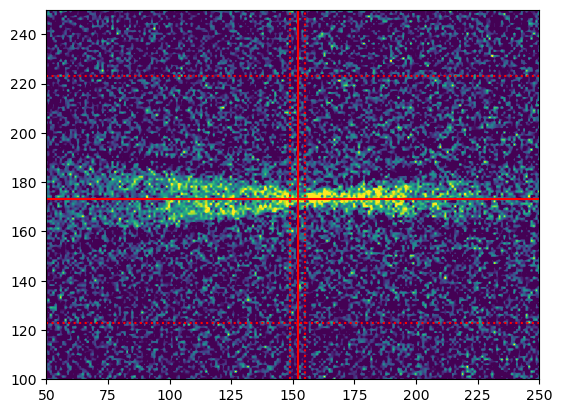

In [139]:
# determine optimal ROI
center = (173, 152)
h = 50
w = 3

single_prc = la.density_builder([images_raw[3]], variables, center, h, w, info_sorted["Csat"], info_sorted["Img_Illumination_Time"], progress_disable = True)

plt.imshow(single_prc.iloc[0]["density"].data, vmin = 0, vmax = 3, cmap = "viridis")

plt.xlim(50, 250)
plt.ylim(100, 250)


plt.axhline(center[0], c = "red")
plt.axhline(center[0] - h, c = "red", ls = ":")
plt.axhline(center[0] + h, c = "red", ls = ":")

plt.axvline(center[1], c = "red")
plt.axvline(center[1] - w, c = "red", ls = ":")
plt.axvline(center[1] + w, c = "red", ls = ":")


plt.show()

In [140]:
%%time
# calculate all density images and apply mask
images_prc = la.density_builder(images_raw, variables, center, h, w, info_sorted["Csat"], info_sorted["Img_Illumination_Time"], progress_disable = False)

|████████████████████████████████████████| 1497/1497 [100%] in 5:39.6 (4.41/s)  
CPU times: total: 2min 30s
Wall time: 5min 39s


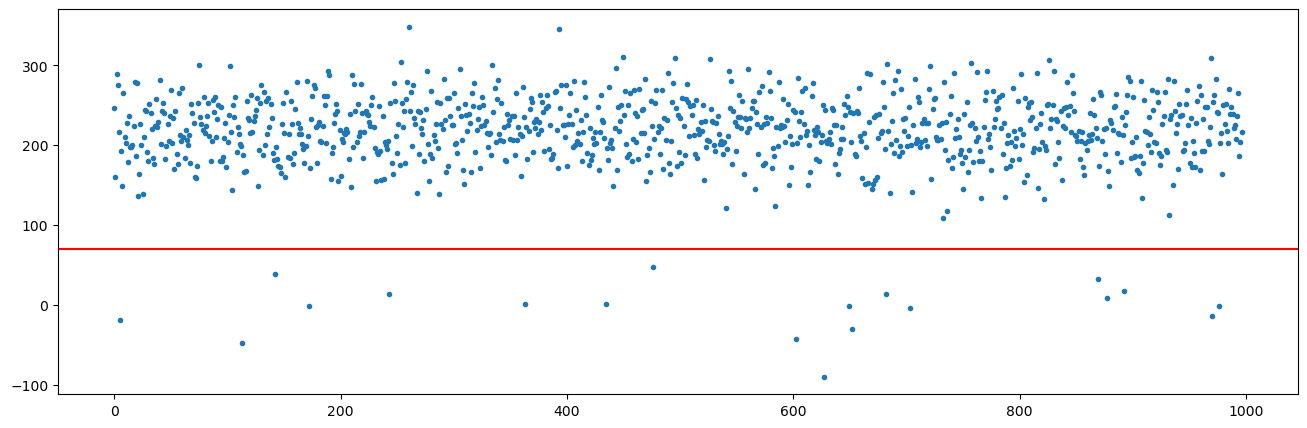

In [141]:
# filter out missed shots
bol = []

for rate in var_vals[1]:

    for i, im in images_prc[images_prc["Vcrit_Lattice_Constant"] == rate].iterrows():
        bol.append(np.sum(im["density"].compressed()))

plt.figure(figsize = (16, 5))

plt.plot(bol, ".")
plt.axhline(70, c = "r")

plt.ylim(None, None)

plt.show()

In [142]:
%%time
# filter missed shots
images_fil = la.filter(images_prc, 70)

dropped 30
dropped 131
dropped 133
dropped 613
dropped 637
dropped 652
dropped 721
dropped 791
dropped 802
dropped 854
dropped 869
dropped 946
dropped 949
dropped 952
dropped 990
dropped 1026
dropped 1057
dropped 1107
dropped 1125
dropped 1135
dropped 1253
dropped 1288
dropped 1320
dropped 1349
dropped 1390
dropped 1451
CPU times: total: 281 ms
Wall time: 400 ms


In [143]:
%%time
# group by loop variables and average over iterations
images_grp = la.group(images_fil, variables, "i", info_sorted["Csat"], info_sorted["Img_Illumination_Time"])

MULTI MODE
CPU times: total: 52 s
Wall time: 58 s


In [144]:
%%time
# make T4 fits 
images_fit = la.T4_fit(images_grp)

CPU times: total: 2.05 s
Wall time: 3.78 s


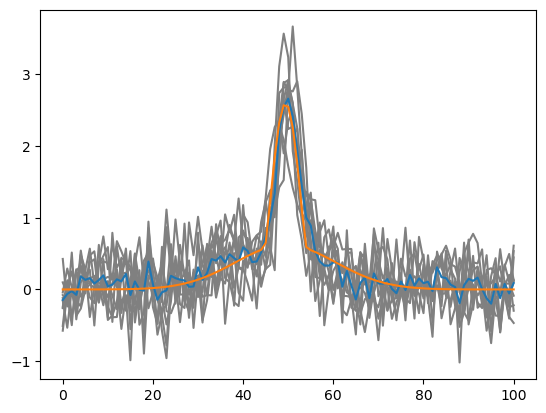

2.595211626935383


In [147]:
field = 0

for i, im in images_fil[(images_fil["Vcrit_Lattice_Constant"] == var_vals[1][field]) & (images_fil["Vcrit_Freq_Diff_kHz"] == 14)].iterrows():

    T4 = np.mean(im["density"], axis = 1).compressed()
    pos = np.arange(0, len(T4))
    plt.plot(pos, T4, color = "grey")

T4 = np.mean(images_fit["density"][field], axis = 1).compressed()
pos = np.arange(0, len(T4))

plt.plot(pos, T4)

plt.plot(la.gauss_parab(np.linspace(0, len(T4), len(T4)), images_fit["T4_params"].iloc[field][0],
                                                          images_fit["T4_params"].iloc[field][1],
                                                          images_fit["T4_params"].iloc[field][2],
                                                          images_fit["T4_params"].iloc[field][3],
                                                          images_fit["T4_params"].iloc[field][4],))

plt.show()

print(images_fit["T4_peak"][field])

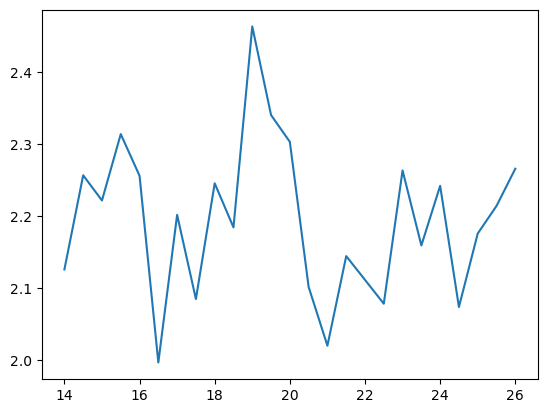

In [146]:
sub = images_fit[images_fit["Vcrit_Lattice_Constant"] == 0.7]

plt.plot(sub["Vcrit_Freq_Diff_kHz"], sub["T4_run_peak"])
plt.show()

In [78]:
a = np.array([1, 2, 3])

np.repeat(a, 3)

array([1, 1, 1, 2, 2, 2, 3, 3, 3])

In [92]:
def response(images, index, column, index_0, index_length):
    """
    Function:
        This function calculates the response from the T4 peaks extracted
        from both fitting and running average methods.

    Arguments:
        images  -- {pandas dataframe} densities for all combinations of loop variables plus T4 peaks
        index   -- {string} loop variable on y-axis
        index_0 -- {float} value with respect to which the response is calculated

    Returns:
        {pandas dataframe} additionally containing response from T4 peaks
    """

    images_res = images.sort_values(by = [index, column])

    a = np.array(images_res["T4_peak"])
    a0 = np.repeat(np.array(images_res[images_res[index] == index_0]["T4_peak"]), index_length + 1)

    # a0  = np.tile(b, len(images_res) // len(b))

    # a_run = np.array(images_res["T4_run_peak"])
    # b_run = np.array(images_res[images_res[index] == index_0]["T4_run_peak"])
    # a0_run  = np.tile(b_run, len(images_res) // len(b_run))

    images_res["response"] = a0 / a - np.ones(len(a))
    # images_res["response_run"] = a0_run / a_run - np.ones(len(a_run))

    return images_res, a, a0

In [93]:
%%time
# calculate response
images_res, a, a0 = response(images_fit, "Vcrit_Freq_Diff_kHz", "Vcrit_Lattice_Constant", 14, len(var_vals[2]))

156
156
CPU times: total: 0 ns
Wall time: 3 ms


# Visualization

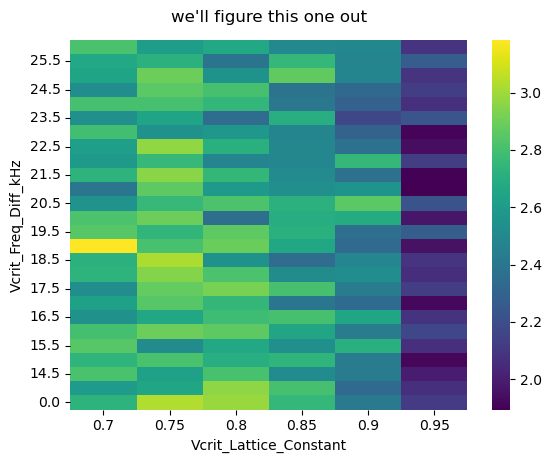

In [99]:
la.visualize(images_fit, variables[2], variables[1], "T4_peak", "we'll figure this one out", vmin = None, vmax = None, cmap = "viridis")

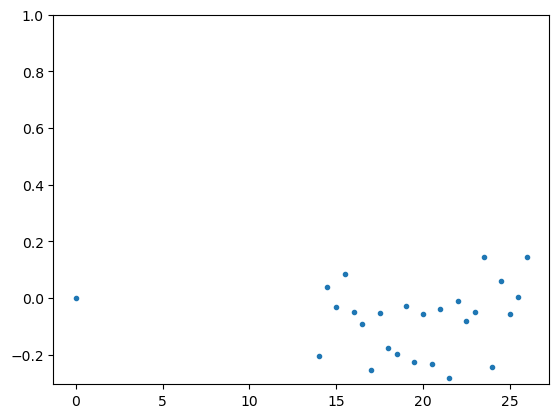

In [67]:
heat = images_res.pivot(index = "Vcrit_Freq_Diff_kHz", columns = "Vcrit_Lattice_Constant", values = "response")
# heat_run = images_res.pivot(index="Acc_heat_freq", columns="RF23_Sweep_Rate", values="response_run")

plt.plot(heat[0.75], ".")
# plt.plot(heat_run[70], ".")

plt.ylim(None, 1)

plt.show()

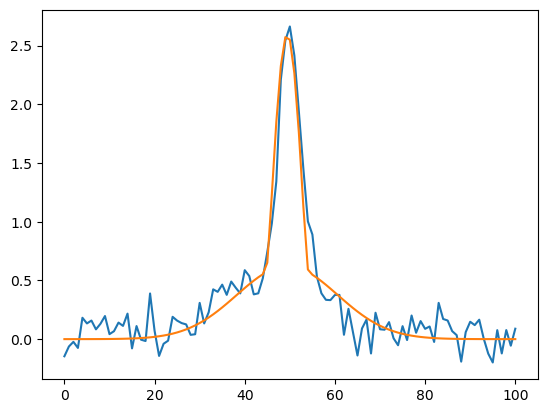

[6.528140828263473, 1.1211825723640065]


In [118]:
field = 0

T4 = np.mean(images_fit["density"].iloc[field], axis = 1).compressed()
pos = np.arange(0, len(T4))

plt.plot(pos, T4)

plt.plot(la.gauss_parab(np.linspace(0, len(T4), len(T4)), images_fit["T4_params"].iloc[field][0],
                                                          images_fit["T4_params"].iloc[field][1],
                                                          images_fit["T4_params"].iloc[field][2],
                                                          images_fit["T4_params"].iloc[field][3],
                                                          images_fit["T4_params"].iloc[field][4],))

# plt.plot(pos, parab(pos, 2.3, 50, 5))

plt.show()

print(images_fit["temperature"].iloc[field])

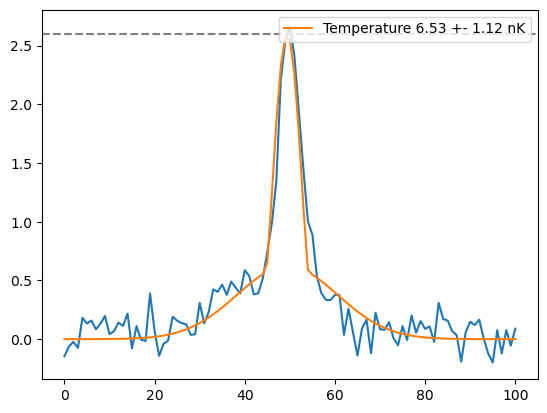

Temperature 6.53 +- 1.12 nK
[  0.62103582  49.91488234 254.66512287   1.97417581   4.74497788]



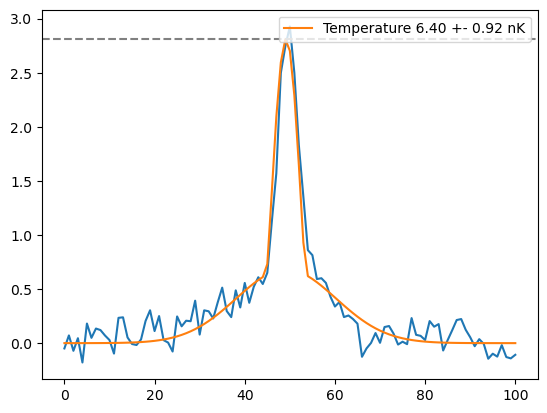

Temperature 6.40 +- 0.92 nK
[  0.68114202  49.66088668 249.79099642   2.13346406   4.50645032]



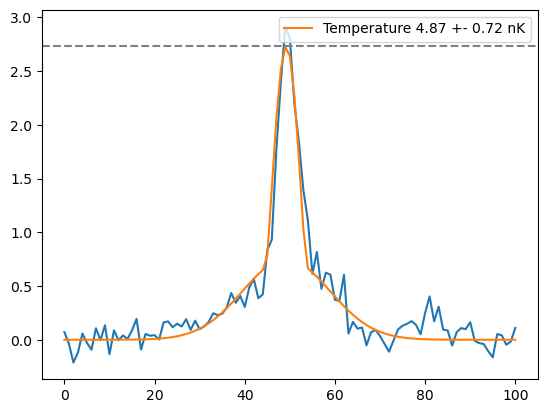

Temperature 4.87 +- 0.72 nK
[  0.75118347  49.70381794 189.81255655   1.97999995   4.58627837]



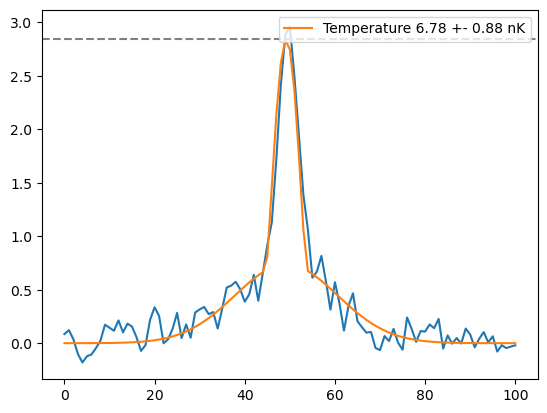

Temperature 6.78 +- 0.88 nK
[  0.73650737  49.70431093 264.49441842   2.10585859   4.60867214]



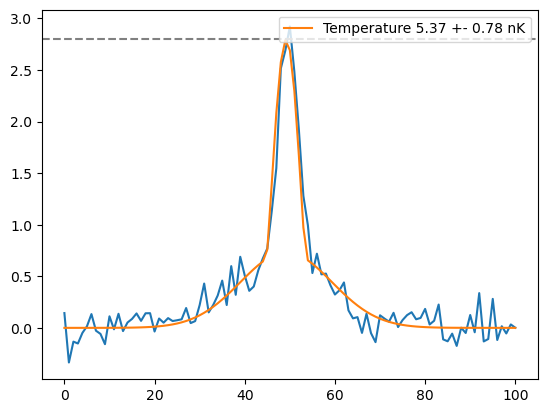

Temperature 5.37 +- 0.78 nK
[  0.73258625  49.6791436  209.40570041   2.06354581   4.5081853 ]



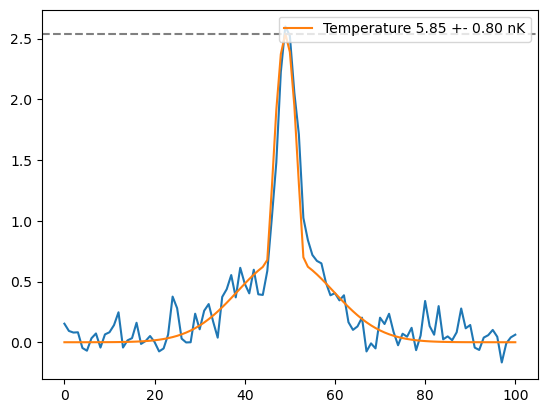

Temperature 5.85 +- 0.80 nK
[  0.69415816  49.5187289  228.39236328   1.84773662   4.21256617]



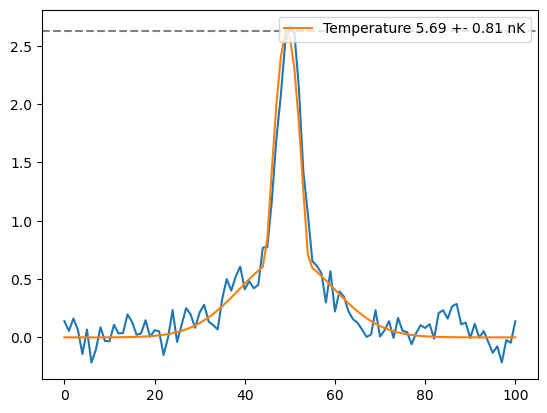

Temperature 5.69 +- 0.81 nK
[  0.68836235  49.84794561 222.00681394   1.93674258   5.01311829]



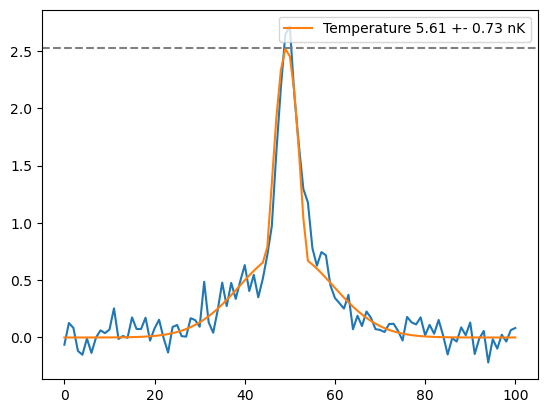

Temperature 5.61 +- 0.73 nK
[  0.7429707   49.7333235  218.69957869   1.78356298   4.64696724]



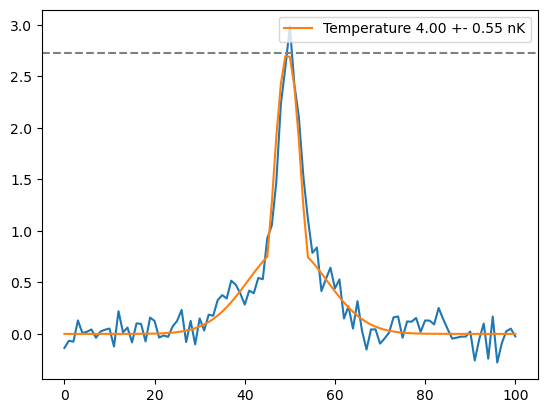

Temperature 4.00 +- 0.55 nK
[  0.85292009  49.96766368 155.89347128   1.87666519   4.54903346]



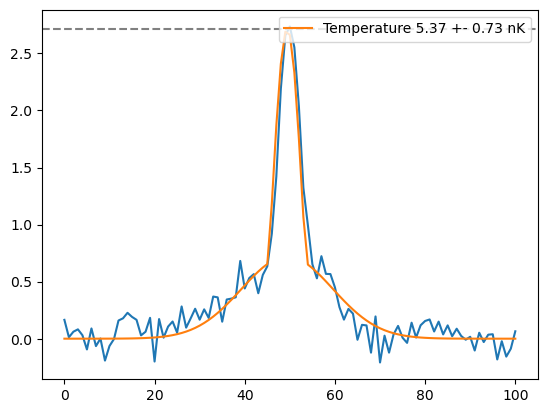

Temperature 5.37 +- 0.73 nK
[  0.71925103  49.90860923 209.31189575   1.9978153    4.4460019 ]



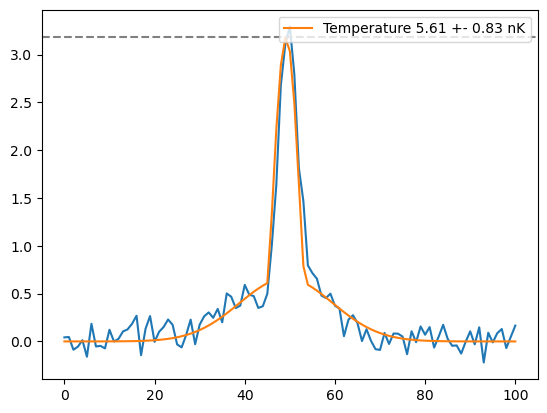

Temperature 5.61 +- 0.83 nK
[  0.66015018  49.66695173 218.87144975   2.52329877   4.23190706]



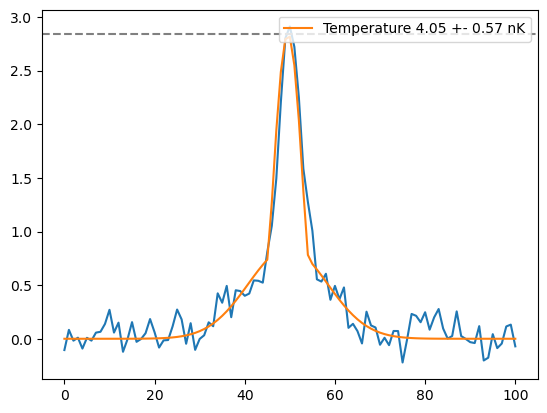

Temperature 4.05 +- 0.57 nK
[  0.84292323  50.07102185 157.90189496   2.00034003   4.64052322]



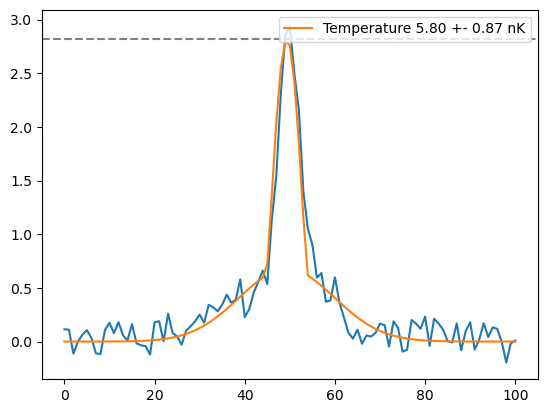

Temperature 5.80 +- 0.87 nK
[  0.67701411  49.83927779 226.42713449   2.14174698   4.71194829]



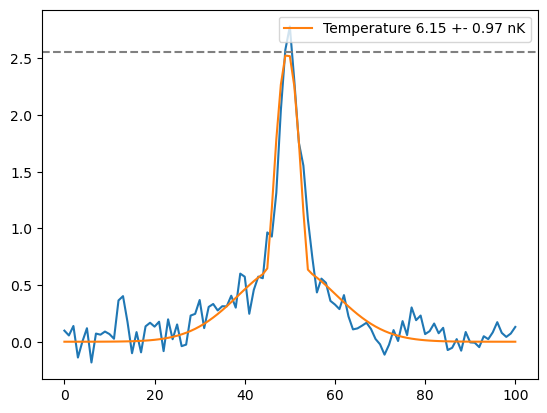

Temperature 6.15 +- 0.97 nK
[  0.67764353  49.97540521 239.83949574   1.87906453   4.65855942]



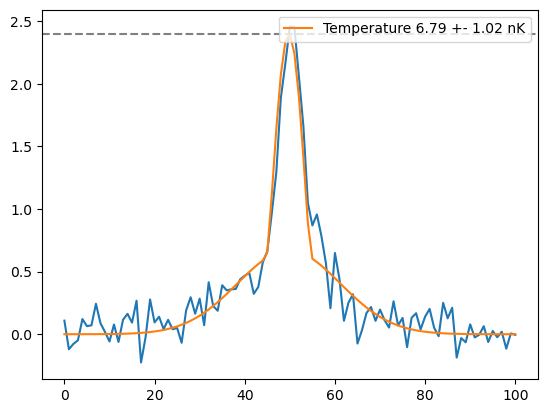

Temperature 6.79 +- 1.02 nK
[  0.66904119  50.27643494 264.68573617   1.73111536   5.0385714 ]



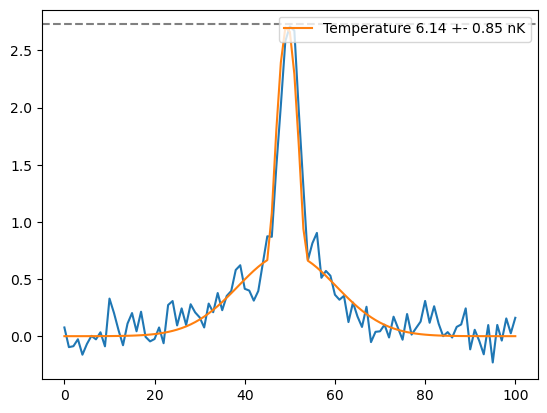

Temperature 6.14 +- 0.85 nK
[  0.72294375  49.89144186 239.63618332   2.00480922   4.21029617]



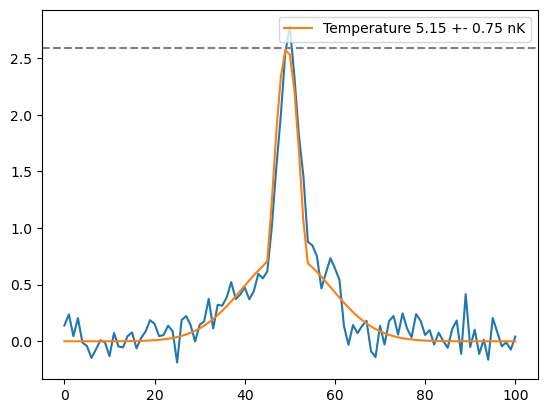

Temperature 5.15 +- 0.75 nK
[  0.7664225   49.85553483 200.84396281   1.82229311   4.48650958]



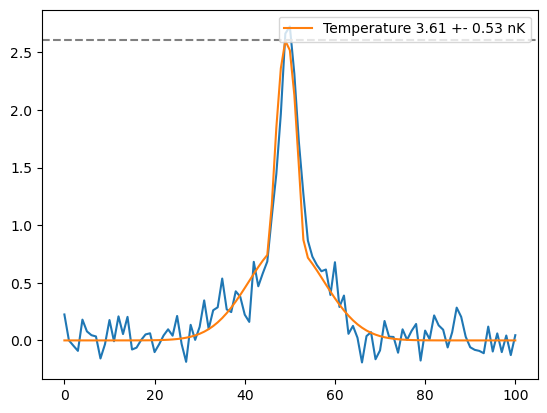

Temperature 3.61 +- 0.53 nK
[  0.845165    49.73902768 140.64811109   1.7653083    4.12958426]



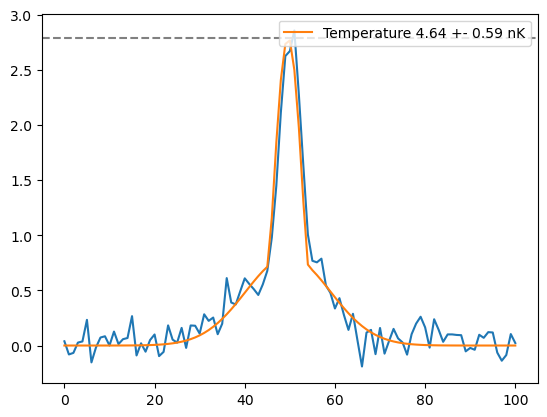

Temperature 4.64 +- 0.59 nK
[  0.8050503   50.10111607 180.89635966   1.98577353   4.51523293]



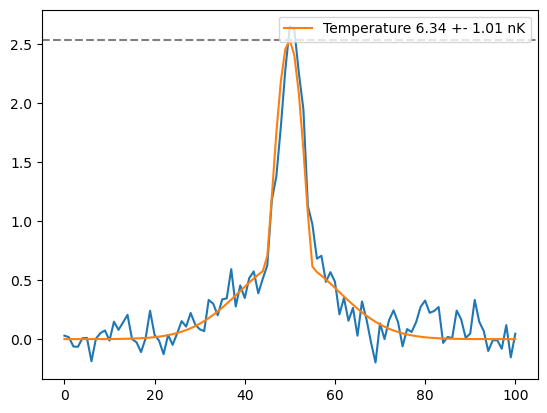

Temperature 6.34 +- 1.01 nK
[  0.66358     50.36530865 247.18695056   1.87255855   5.31228448]



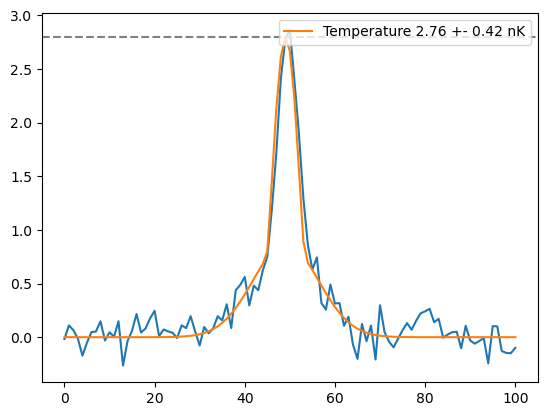

Temperature 2.76 +- 0.42 nK
[  0.8701223   49.57590777 107.80867206   1.9316434    4.34654589]



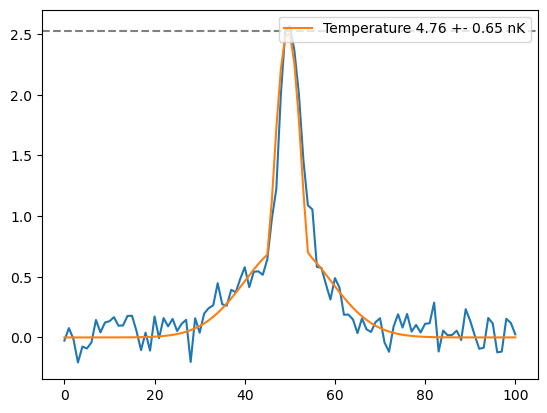

Temperature 4.76 +- 0.65 nK
[  0.76562577  50.06333421 185.78272719   1.76181462   4.56800526]



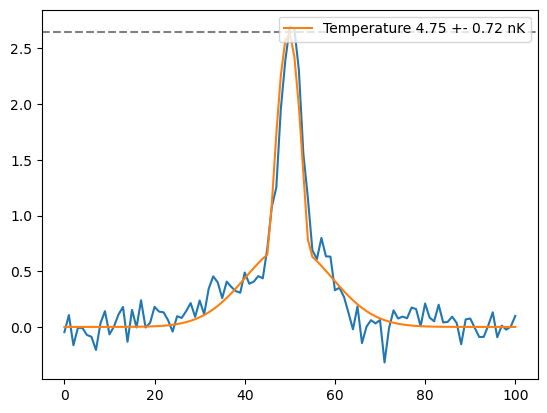

Temperature 4.75 +- 0.72 nK
[  0.73361535  50.21412287 185.46891534   1.91107083   4.71496918]



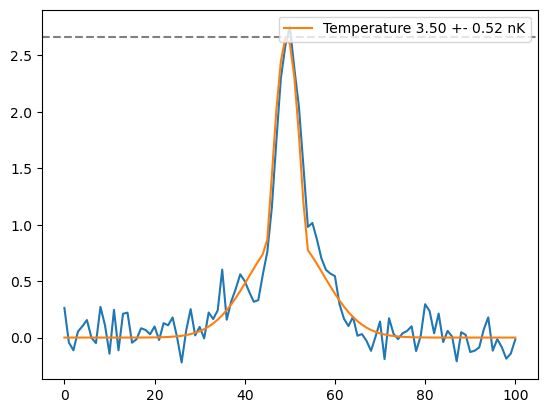

Temperature 3.50 +- 0.52 nK
[  0.91223077  49.80365213 136.65555089   1.7553583    4.64892459]



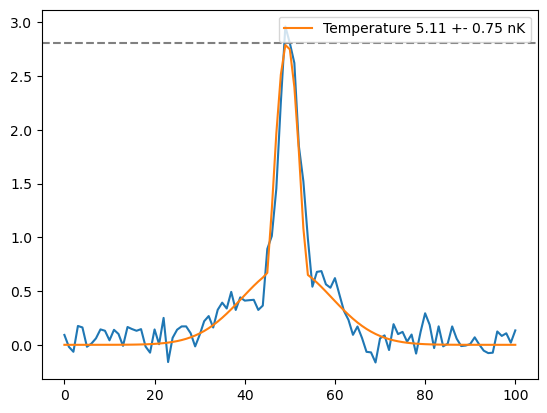

Temperature 5.11 +- 0.75 nK
[  0.72550094  49.86880296 199.20064046   2.08755039   4.49144439]



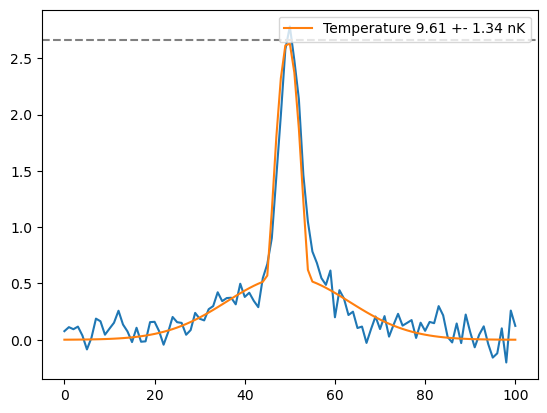

Temperature 9.61 +- 1.34 nK
[  0.55981642  50.05823972 375.02723618   2.09812437   4.78609009]



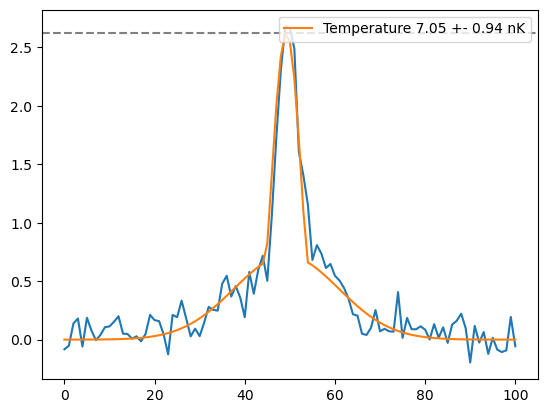

Temperature 7.05 +- 0.94 nK
[  0.71847983  49.73485352 275.1266678    1.90771098   4.74693245]



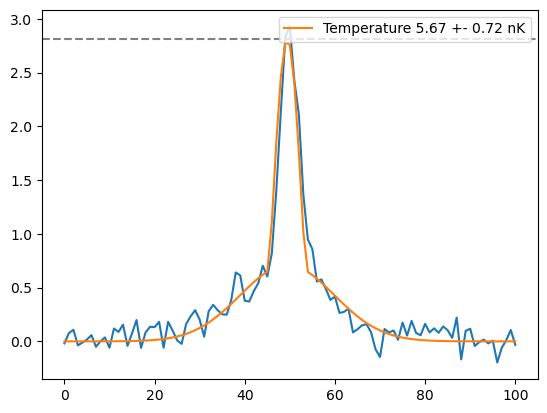

Temperature 5.67 +- 0.72 nK
[  0.71093224  49.92797094 221.14625547   2.10382887   4.29986833]



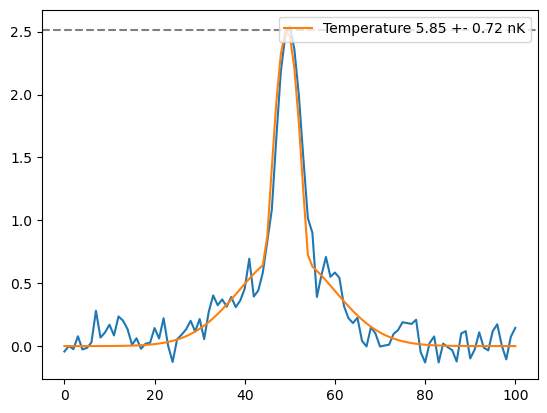

Temperature 5.85 +- 0.72 nK
[  0.7301959   49.8204525  228.0911451    1.78610301   4.99336195]



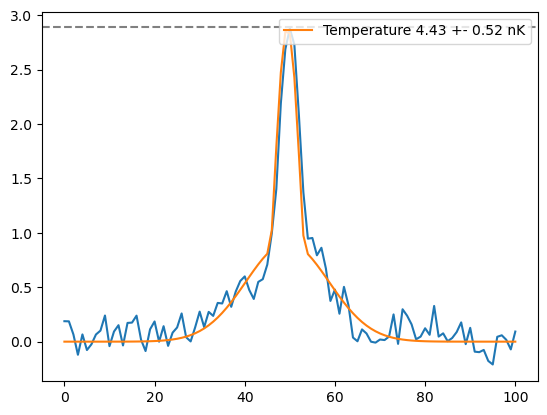

Temperature 4.43 +- 0.52 nK
[  0.90907838  49.95451645 172.78166561   1.98396933   3.90866292]



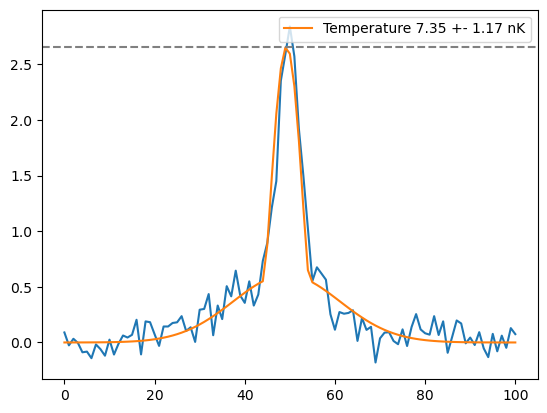

Temperature 7.35 +- 1.17 nK
[  0.60764328  49.76778929 286.53459046   2.05298475   5.09799519]



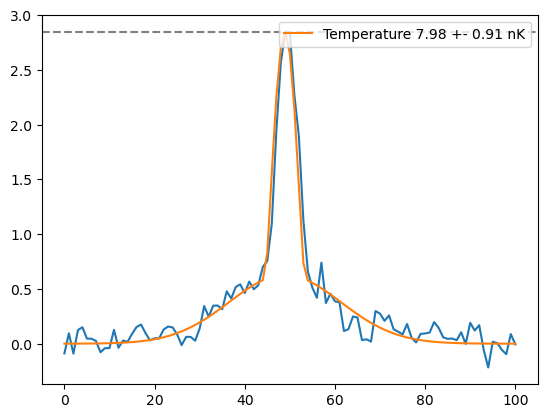

Temperature 7.98 +- 0.91 nK
[  0.62700829  49.40890629 311.25928554   2.21704272   4.49776166]



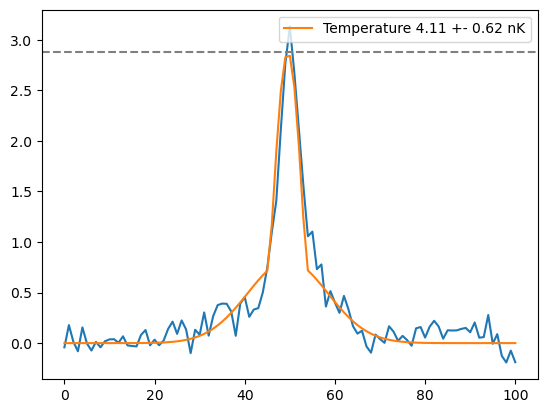

Temperature 4.11 +- 0.62 nK
[  0.81534562  50.03572899 160.40672737   2.06083899   4.42501985]



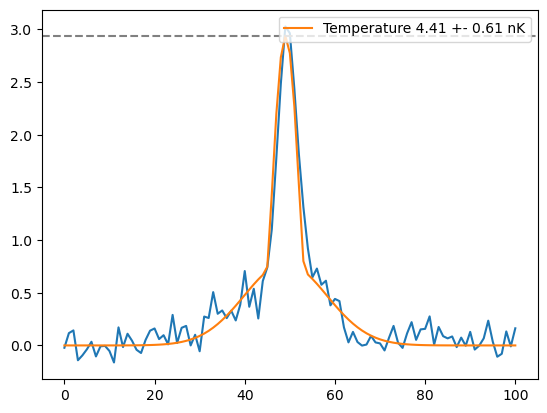

Temperature 4.41 +- 0.61 nK
[  0.7788901   49.54519518 171.91945094   2.16290501   4.24921218]



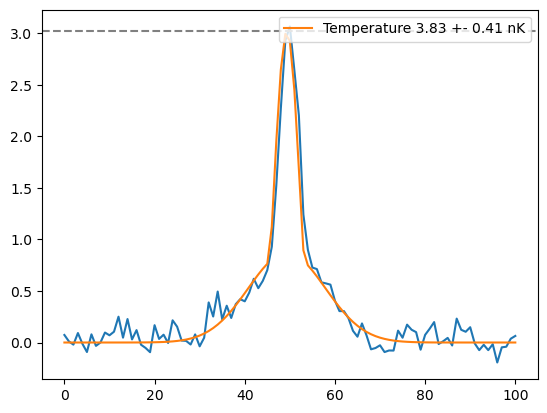

Temperature 3.83 +- 0.41 nK
[  0.86855428  49.82959631 149.28589869   2.15137943   3.97090124]



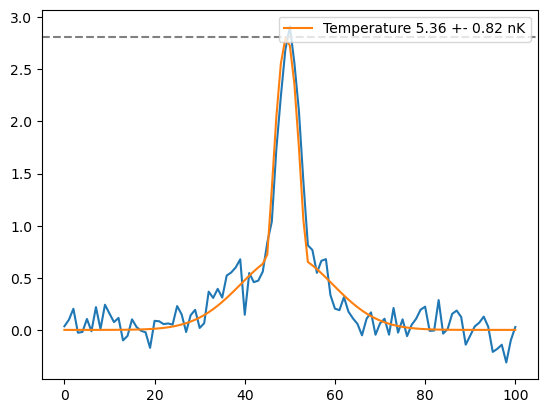

Temperature 5.36 +- 0.82 nK
[  0.72649682  49.77870848 209.22063233   2.08189931   4.54704651]



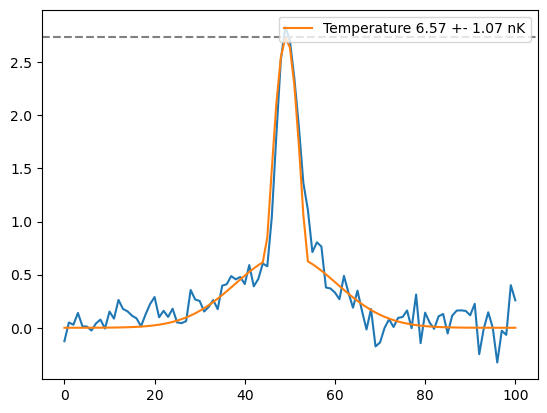

Temperature 6.57 +- 1.07 nK
[  0.68571214  49.66497853 256.42603179   2.05044198   4.7707911 ]



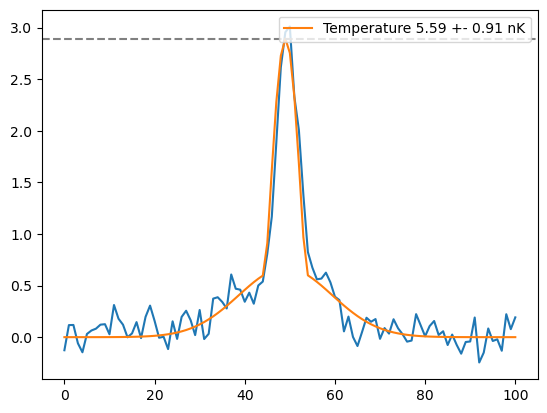

Temperature 5.59 +- 0.91 nK
[  0.67180011  49.53471831 218.02261285   2.22160218   4.73779853]



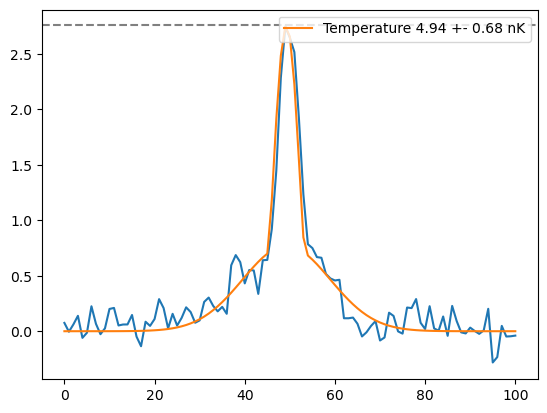

Temperature 4.94 +- 0.68 nK
[  0.76882123  49.73849438 192.55753412   1.9883943    4.14623365]



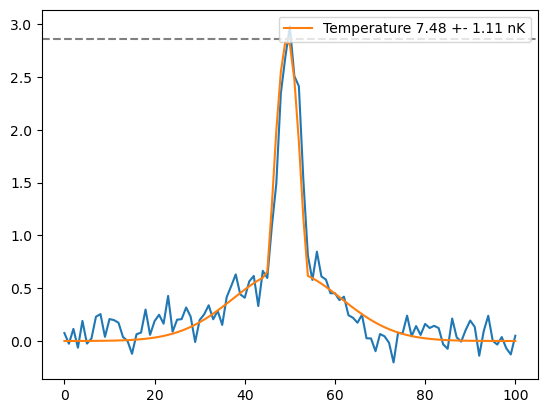

Temperature 7.48 +- 1.11 nK
[  0.66328406  49.91444178 291.88632233   2.19954586   4.61487478]



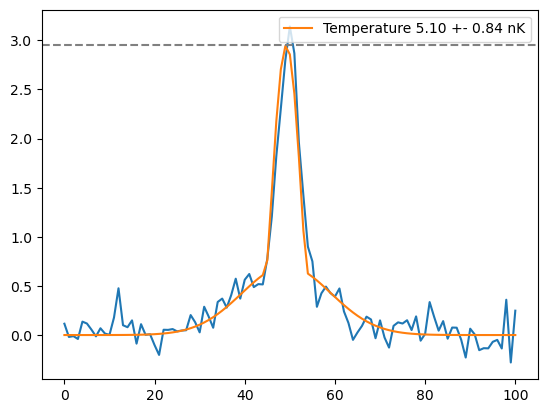

Temperature 5.10 +- 0.84 nK
[  0.70250162  49.72825847 199.05845226   2.25046805   4.61680548]



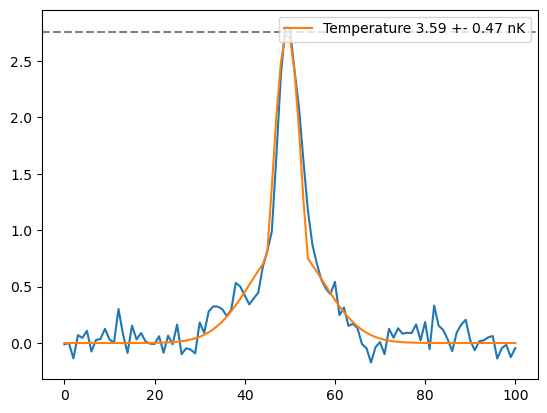

Temperature 3.59 +- 0.47 nK
[  0.86482989  49.91277582 140.05096676   1.89195332   4.69191826]



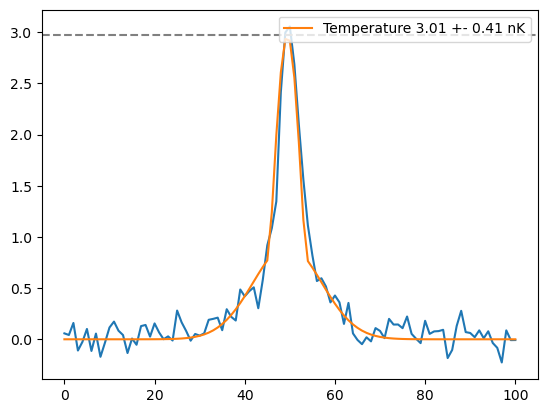

Temperature 3.01 +- 0.41 nK
[  0.91440934  49.94366775 117.42443404   2.05522544   4.30124249]



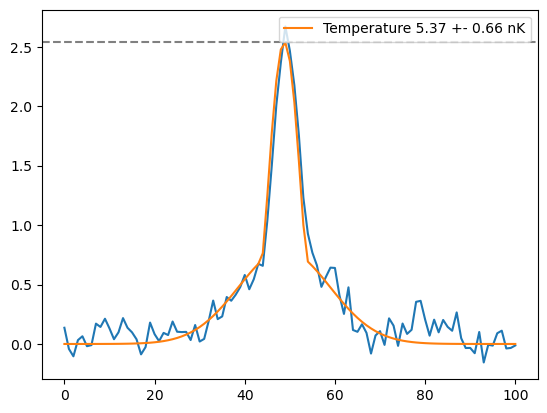

Temperature 5.37 +- 0.66 nK
[  0.79126049  49.2572395  209.54605124   1.75006317   5.07685813]



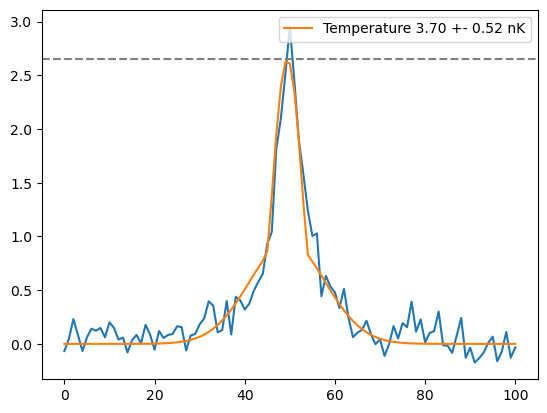

Temperature 3.70 +- 0.52 nK
[  0.95198514  49.93530194 144.25935157   1.69663539   4.6676638 ]



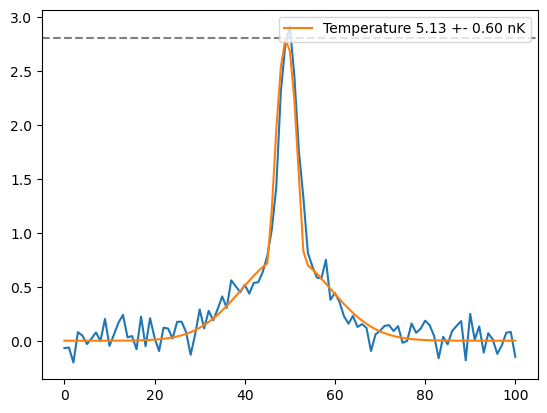

Temperature 5.13 +- 0.60 nK
[  0.78573116  49.7009809  200.0769004    2.01876035   4.11445634]



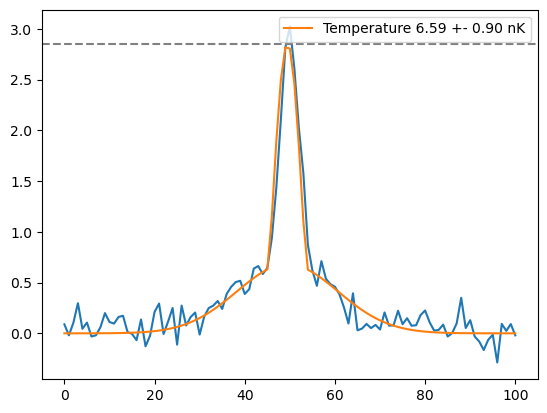

Temperature 6.59 +- 0.90 nK
[  0.68034238  49.96301615 257.04163393   2.17541198   4.42907064]



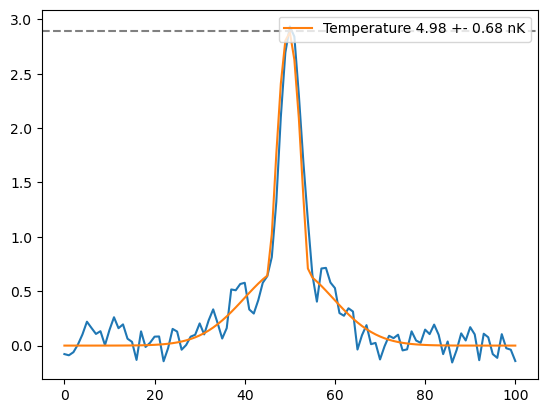

Temperature 4.98 +- 0.68 nK
[  0.72378526  50.23018994 194.1769608    2.16991012   4.49821467]



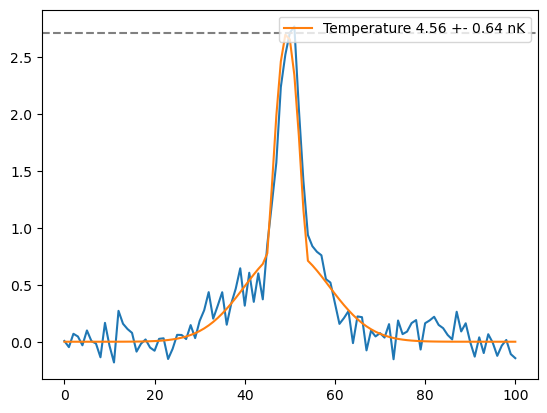

Temperature 4.56 +- 0.64 nK
[  0.80565188  49.84493038 177.99084145   1.91060732   4.61560929]



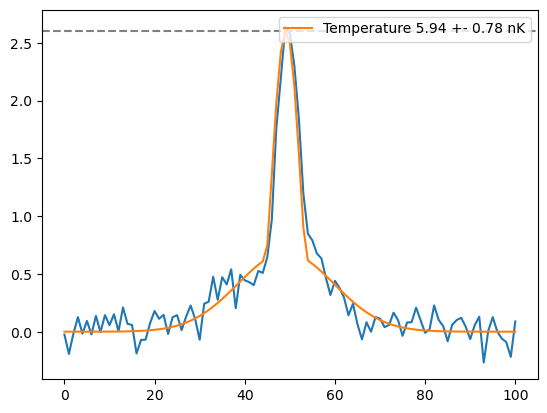

Temperature 5.94 +- 0.78 nK
[  0.68273212  49.63062232 231.83254067   1.92329771   4.54419857]



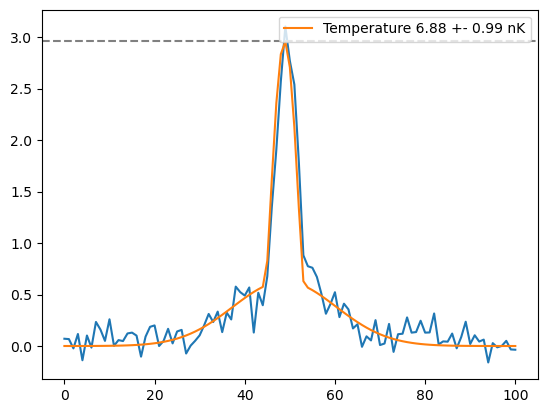

Temperature 6.88 +- 0.99 nK
[  0.6271136   49.31662226 268.28795578   2.33631212   4.36792203]



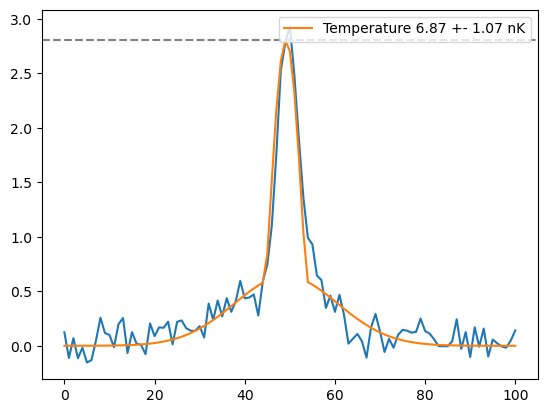

Temperature 6.87 +- 1.07 nK
[  0.63907006  49.64650998 268.02953142   2.16836737   4.79457634]



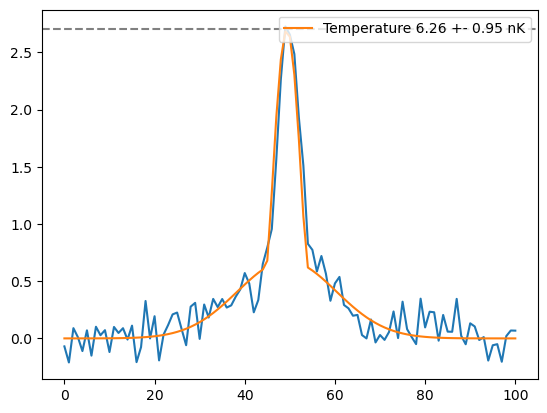

Temperature 6.26 +- 0.95 nK
[  0.67785806  49.83526683 244.17828613   2.02302557   4.59244274]



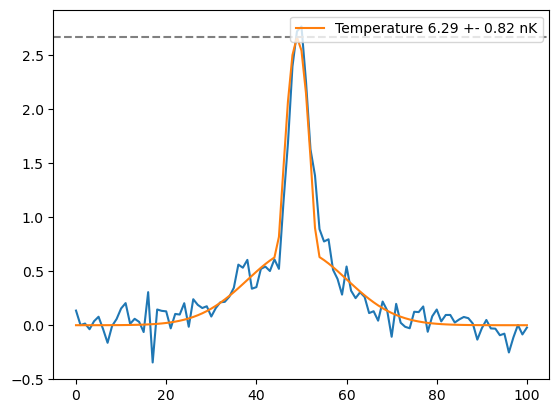

Temperature 6.29 +- 0.82 nK
[  0.69751634  49.56437952 245.50452959   1.96952786   4.57934301]



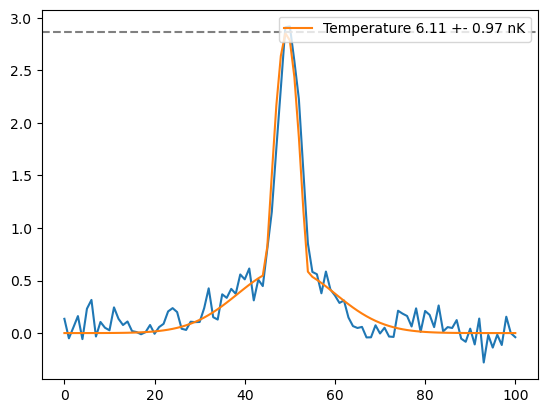

Temperature 6.11 +- 0.97 nK
[  0.61587925  49.75198478 238.38217233   2.24839143   4.91220731]



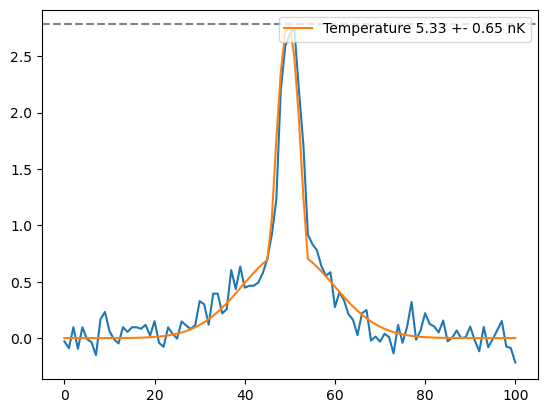

Temperature 5.33 +- 0.65 nK
[  0.77185313  50.13684103 207.98013247   2.01349342   4.40689134]



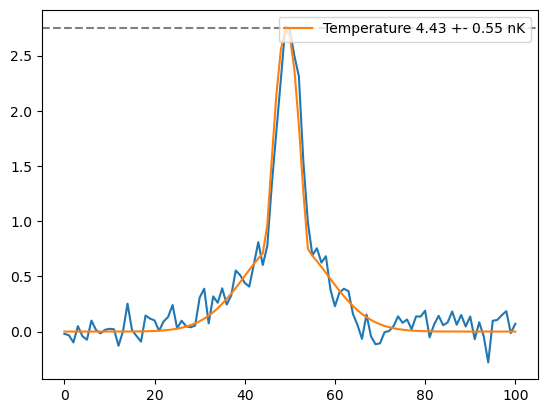

Temperature 4.43 +- 0.55 nK
[  0.83431665  49.74656685 172.80495479   1.91205894   4.90603377]



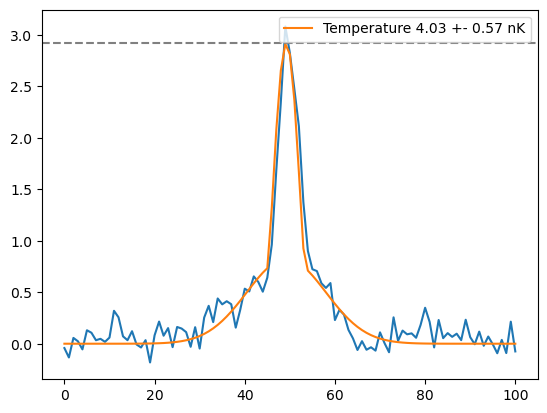

Temperature 4.03 +- 0.57 nK
[  0.82300903  49.7137962  157.08844838   2.09774136   4.24273882]



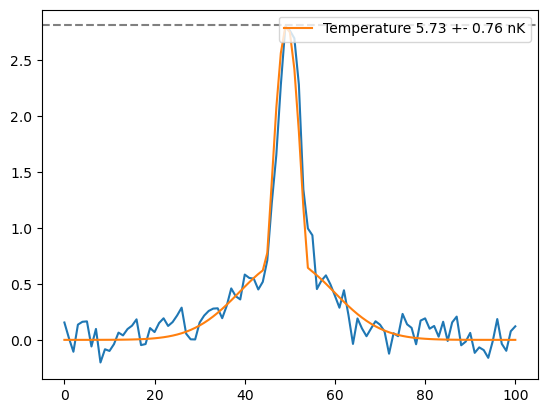

Temperature 5.73 +- 0.76 nK
[  0.70735533  49.82145717 223.68313344   2.1116958    4.75596779]



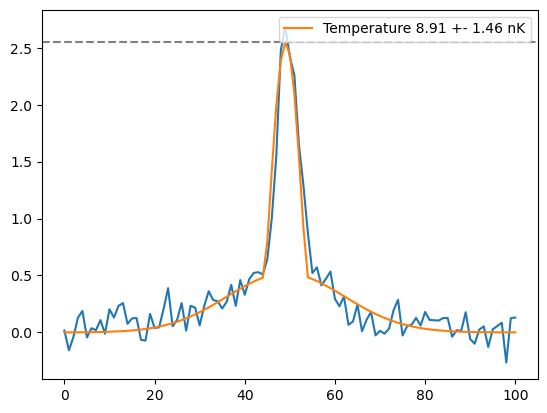

Temperature 8.91 +- 1.46 nK
[  0.51813241  49.59691673 347.67873988   2.02972179   4.89806605]



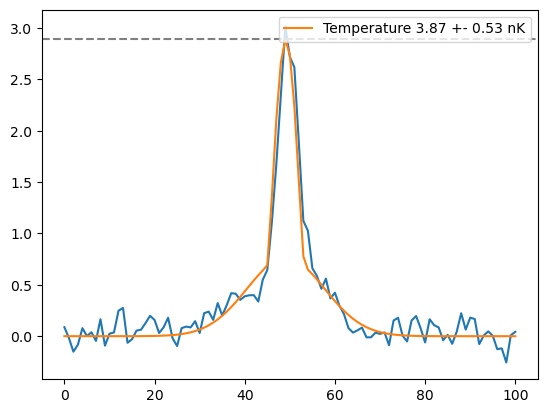

Temperature 3.87 +- 0.53 nK
[  0.76278083  49.58872101 150.9074109    2.12624777   4.20266183]



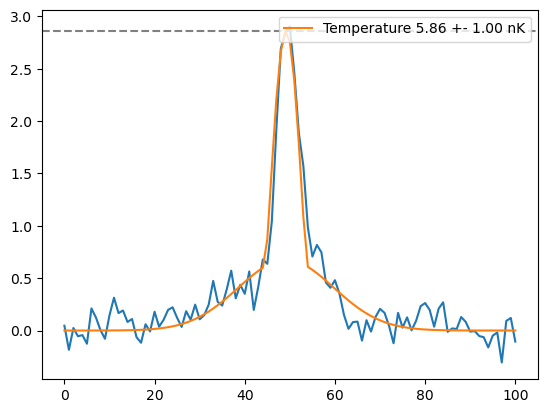

Temperature 5.86 +- 1.00 nK
[  0.67424611  49.65424382 228.6354885    2.18792747   4.80200712]



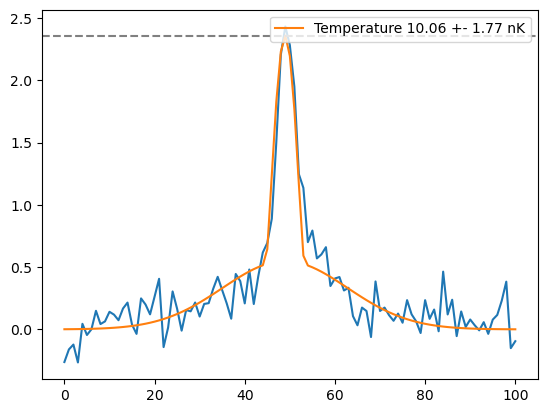

Temperature 10.06 +- 1.77 nK
[  0.54822208  49.43060737 392.40147219   1.81124634   4.34712918]



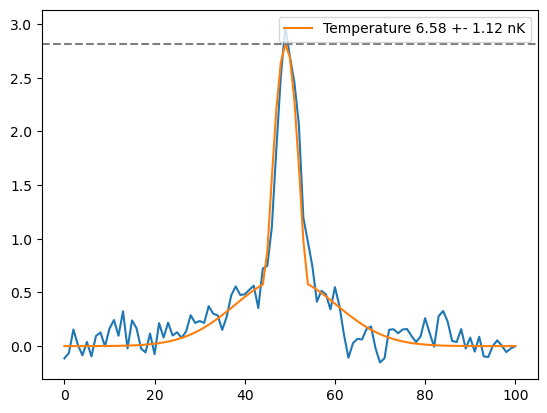

Temperature 6.58 +- 1.12 nK
[  0.63531805  49.57175131 256.52628549   2.18132414   4.77944188]



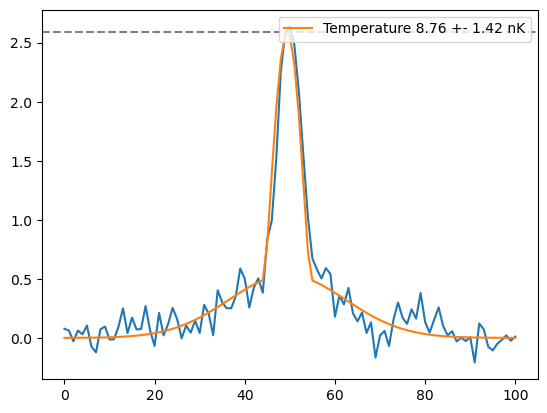

Temperature 8.76 +- 1.42 nK
[  0.53245749  49.92367748 341.8505144    2.06042513   5.27342377]



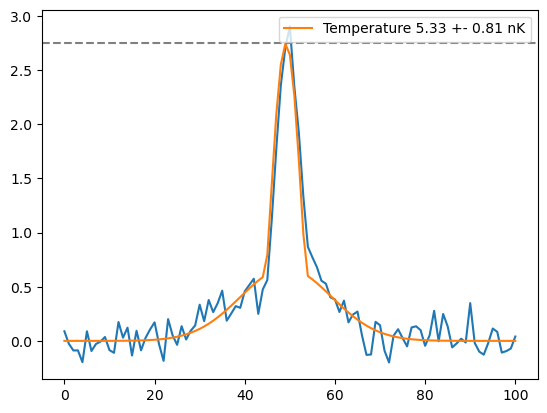

Temperature 5.33 +- 0.81 nK
[  0.67125645  49.64936265 207.87448698   2.07708051   4.67587733]



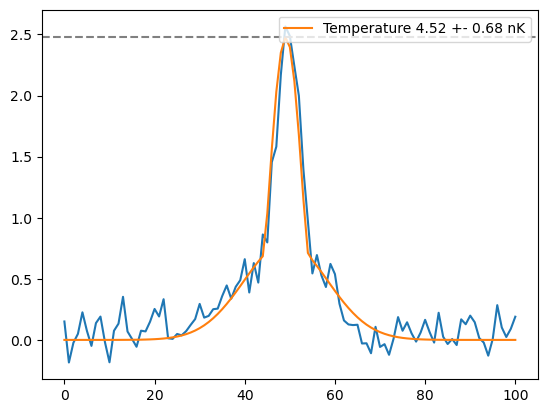

Temperature 4.52 +- 0.68 nK
[  0.79632132  49.60397083 176.29892493   1.682181     5.06126718]



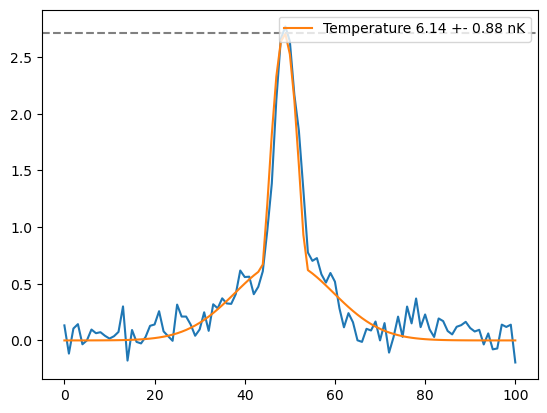

Temperature 6.14 +- 0.88 nK
[  0.69693003  49.26218734 239.60813786   2.01572964   5.00202674]



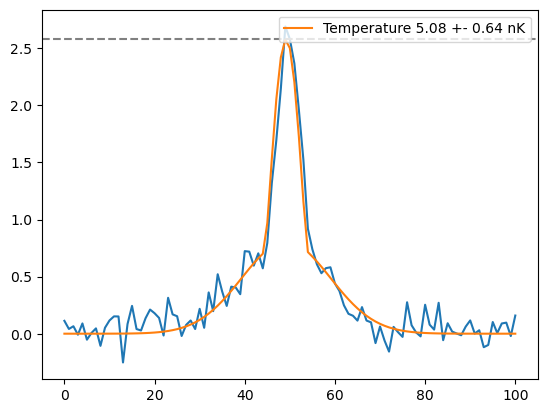

Temperature 5.08 +- 0.64 nK
[  0.80338507  49.66739196 198.31464641   1.77696183   4.9010712 ]



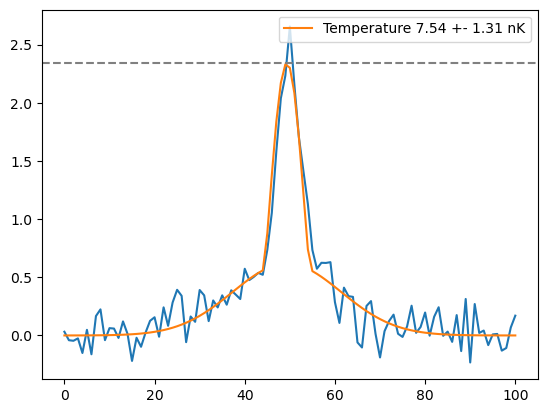

Temperature 7.54 +- 1.31 nK
[  0.61765193  49.84000446 294.25221854   1.72485611   5.28921309]



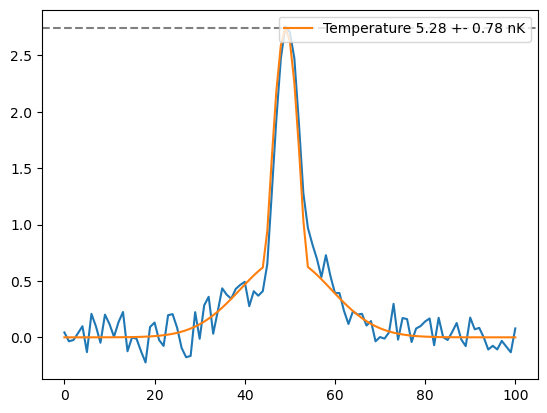

Temperature 5.28 +- 0.78 nK
[  0.70330243  49.56454612 205.83716619   2.04086529   4.83294732]



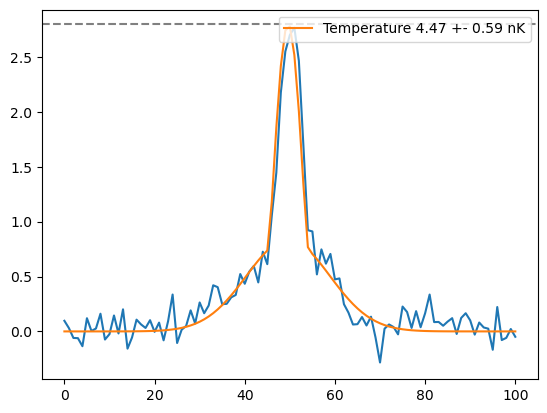

Temperature 4.47 +- 0.59 nK
[  0.83508749  50.1144148  174.46483718   1.96584877   4.53796326]



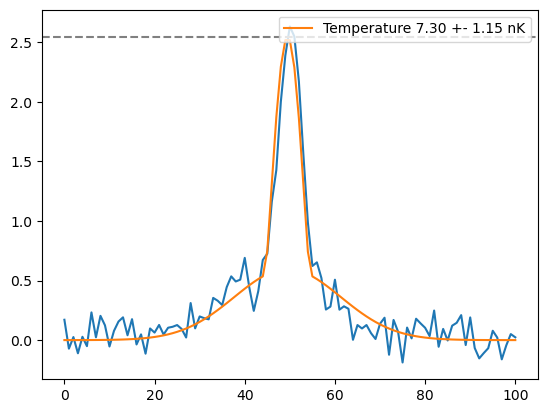

Temperature 7.30 +- 1.15 nK
[  0.59600227  49.98755732 284.66738943   1.95131872   5.1224367 ]



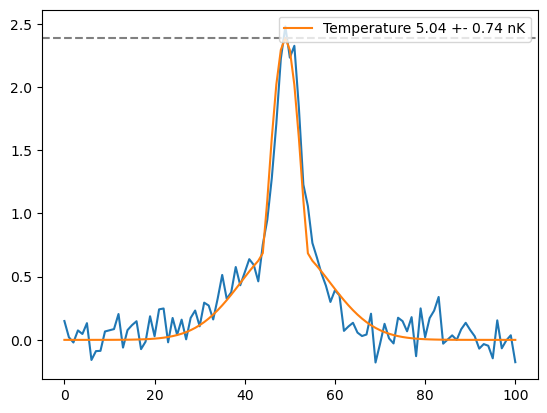

Temperature 5.04 +- 0.74 nK
[  0.75385194  49.4869029  196.74627646   1.63395183   5.20394569]



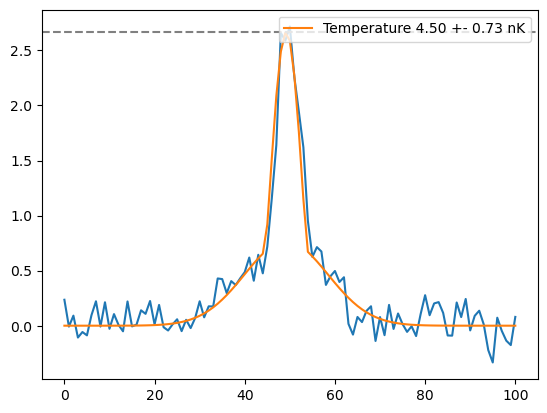

Temperature 4.50 +- 0.73 nK
[  0.76450038  49.68990995 175.66068611   1.90351198   4.87630581]



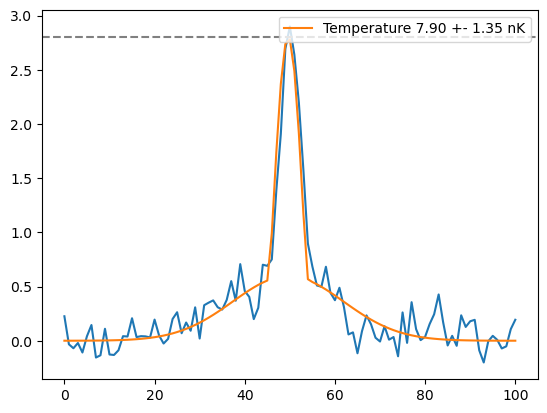

Temperature 7.90 +- 1.35 nK
[  0.59594505  50.11988013 308.04669522   2.20855012   4.47586813]



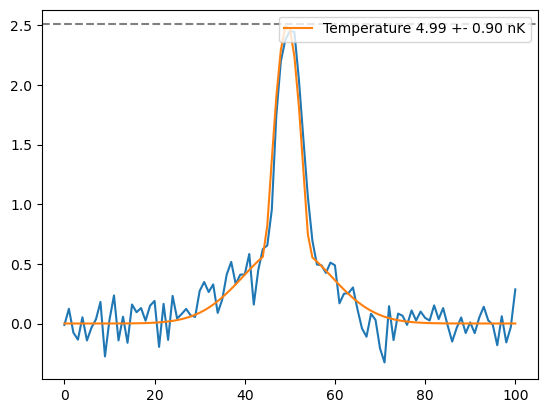

Temperature 4.99 +- 0.90 nK
[  0.65157707  49.91471956 194.61526638   1.85803209   5.16128256]



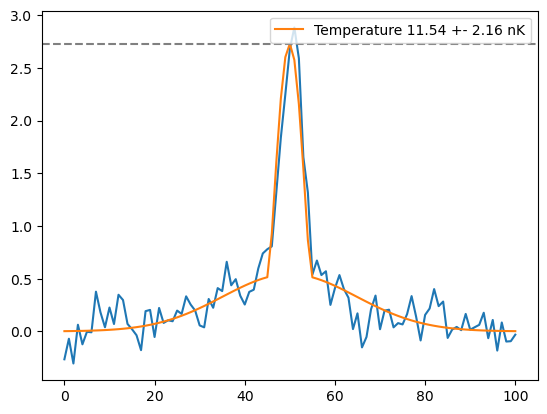

Temperature 11.54 +- 2.16 nK
[  0.5431036   50.45056875 450.22743334   2.18723106   4.85220848]



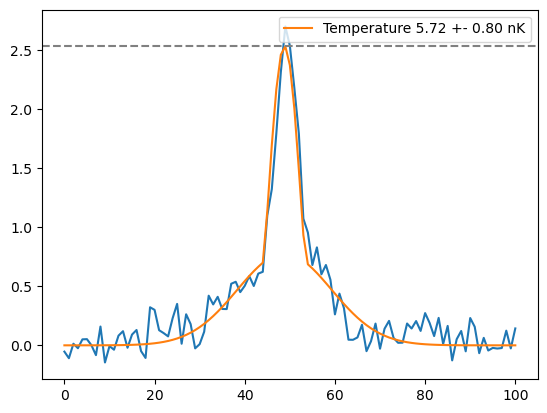

Temperature 5.72 +- 0.80 nK
[  0.77650704  49.29640445 223.15678985   1.76178481   4.87959623]



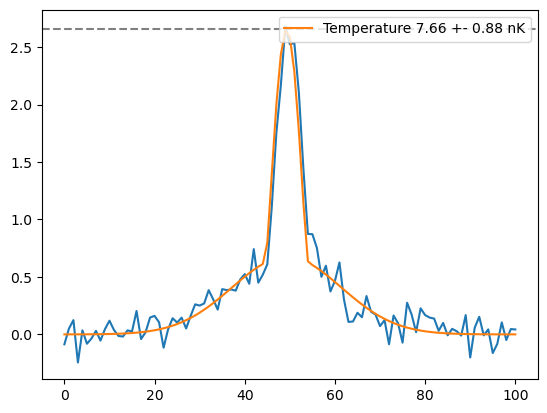

Temperature 7.66 +- 0.88 nK
[  0.67414405  49.79196704 298.86709958   1.98020777   4.82572076]



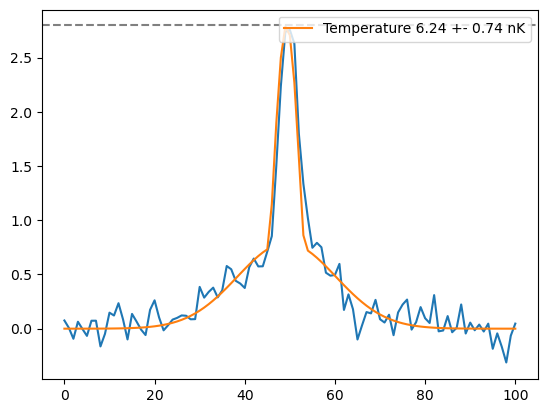

Temperature 6.24 +- 0.74 nK
[  0.79028173  49.77569702 243.32857636   2.01243647   4.06988846]



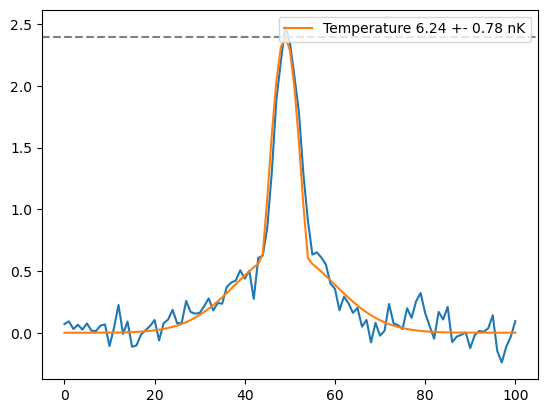

Temperature 6.24 +- 0.78 nK
[  0.64907744  49.43512763 243.30038613   1.75039754   5.25285234]



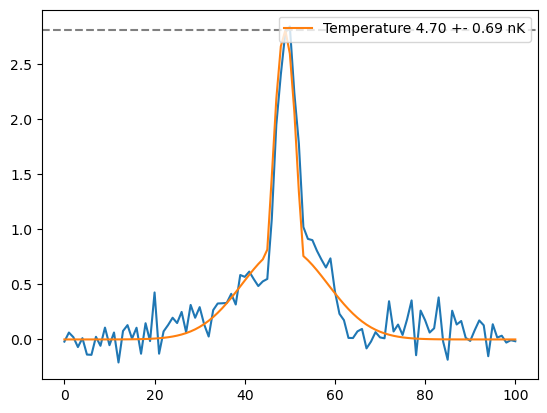

Temperature 4.70 +- 0.69 nK
[  0.83005786  49.394647   183.36432921   1.9744882    4.13120374]



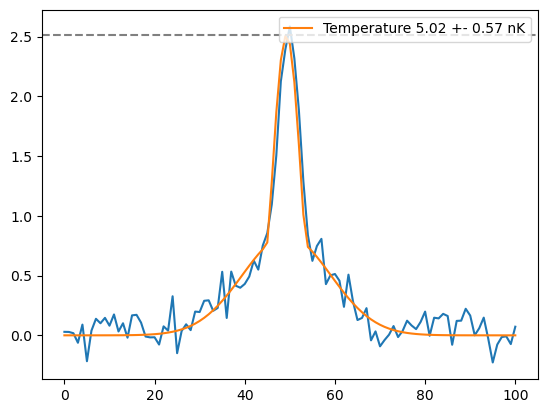

Temperature 5.02 +- 0.57 nK
[  0.83152005  49.75253236 195.85196514   1.68250371   4.42235256]



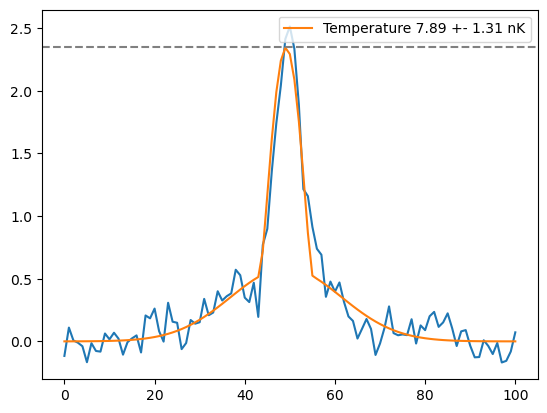

Temperature 7.89 +- 1.31 nK
[  0.58284804  49.66229317 307.88725543   1.76350399   5.93574636]



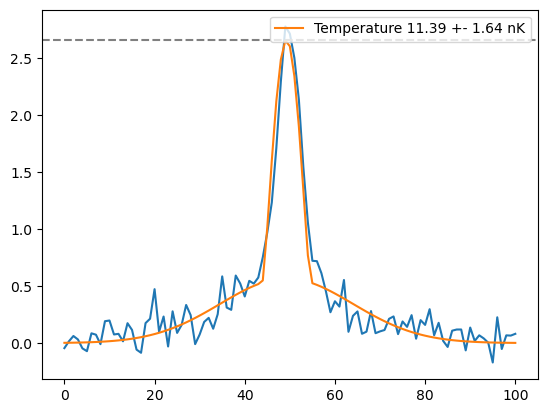

Temperature 11.39 +- 1.64 nK
[  0.56565644  49.76512158 444.14127474   2.09404257   5.44040999]



KeyboardInterrupt: 

In [18]:
for i, im in images_fit.iterrows():

    T4 = np.mean(im["density"], axis = 1).compressed()
    pos = np.arange(0, len(T4))

    plt.plot(pos, T4)

    plt.plot(la.gauss_parab(np.linspace(0, len(T4), len(T4)), im["T4_params"][0],
                                                              im["T4_params"][1],
                                                              im["T4_params"][2],
                                                              im["T4_params"][3],
                                                              im["T4_params"][4],), label = f"Temperature {im["temperature"][0]:.2f} +- {im["temperature"][1]:.2f} nK")

    # plt.axhline(im["T4_params"][0] + im["T4_params"][3], color = "grey", ls = "--")
    plt.axhline(im["T4_peak"], color = "grey", ls = "--")

    plt.legend(loc = 1)

    plt.show()

    # print(f"Temperature {im["temperature"][0]:.2f} +- {im["temperature"][1]:.2f} nK @ {im["FB_Img"]:.0f} G")
    print(f"Temperature {im["temperature"][0]:.2f} +- {im["temperature"][1]:.2f} nK")
    print(im["T4_params"])
    print("")

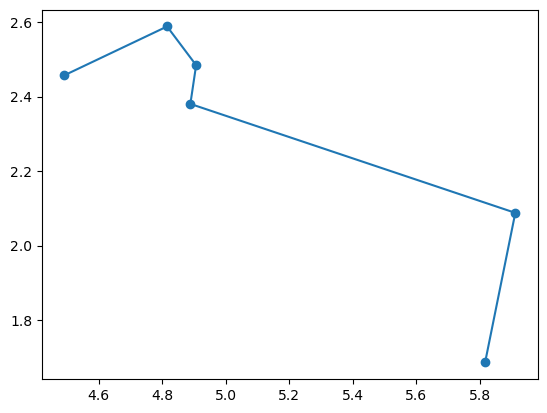

In [24]:
peeeek = []
TTT = []

for i, im in images_fit.iterrows():
    peeeek.append(im["T4_params"][-2])
    TTT.append(im["temperature"][0])

plt.scatter(TTT, peeeek)
plt.plot(TTT, peeeek)

plt.show()


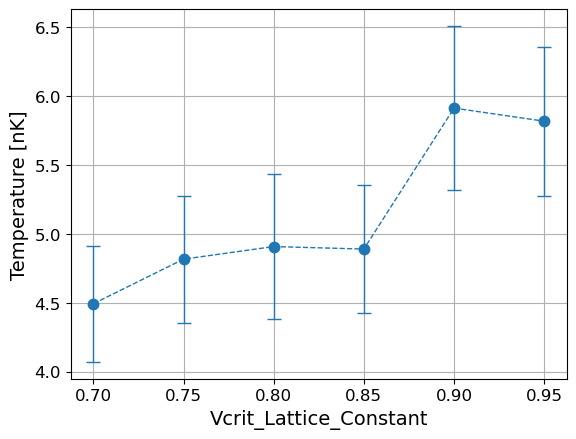

In [26]:
x = np.array(images_fit["Vcrit_Lattice_Constant"].tolist())
y = np.array(images_fit["temperature"].tolist())

plt.errorbar(x, y[:, 0], y[:, 1], marker = ".", ms = 15, lw = 1, ls = "--", elinewidth = 1, capsize = 5)

plt.xlabel(f"{variables[1]}", fontsize = 14)
plt.ylabel("Temperature [nK]", fontsize = 14)

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.grid(visible = True, which = "both")

plt.show()